In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from grid import create_grid

In [2]:
# data
ind = 15 #np.random.randint(0, 19)
elev_map = np.load('./data/elev_map{}.npy'.format(ind))
dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))

map_res = 0.15
margin = 0.3

In [3]:
grid, elev_grid = create_grid(elev_map, map_res=map_res, safety_distance=0., margin=margin)

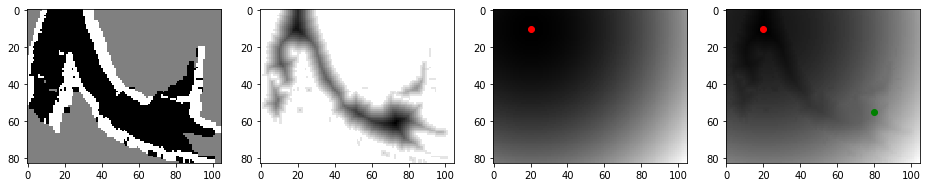

In [4]:
num_iters=100
influence_r=0.5
repulsive_coef=200
attractive_coef=1./100

nrows, ncols = grid.shape
[x, y] = np.meshgrid(np.arange(ncols), np.arange(nrows))
# Compute repulsive force
d = bwdist(grid==0)
# Rescale and transform distances
d2 = d/100. + 1
d0 = 1 + influence_r
nu = repulsive_coef
repulsive = nu*((1./d2 - 1./d0)**2)
repulsive[d2 > d0] = 0


# Compute attractive force
start = [80, 55]
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal = [j, i]
        break
goal = [20, 10]
xi = attractive_coef
attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
# Combine terms
total = attractive + repulsive

plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
plt.imshow(grid, cmap='gray')

plt.subplot(1,4,2)
plt.imshow(repulsive, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(attractive, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')

plt.subplot(1,4,4)
plt.imshow(total, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')

In [5]:
def construct_path(total_potential, start_coords, end_coords, max_its):
    # GradientBasedPlanner : This function plans a path through a 2D
    # environment from a start to a destination based on the gradient of the
    # function f which is passed in as a 2D array. The two arguments
    # start_coords and end_coords denote the coordinates of the start and end
    # positions respectively in the array while max_its indicates an upper
    # bound on the number of iterations that the system can use before giving
    # up.
    # The output, route, is an array with 2 columns and n rows where the rows
    # correspond to the coordinates of the robot as it moves along the route.
    # The first column corresponds to the x coordinate and the second to the y coordinate
    gy, gx = np.gradient(-total_potential)
    route = [np.array(start_coords)]
    for i in range(max_its):
        current_point = np.array(route[-1])
        #print(sum( abs(current_point-end_coords) ))
        if sum( abs(current_point-end_coords) ) < 2.0:
            print('Reached the goal !')
            break
        ix = np.clip(int(current_point[1]), 0, gx.shape[0]-1)
        iy = np.clip(int(current_point[0]), 0, gx.shape[1]-1)
        vx = gx[ix, iy]; vy = gy[ix, iy]
        dt = 1/(1e-8+np.linalg.norm([vx, vy]))
        next_point = current_point + dt*np.array( [vx, vy] )
        route.append(next_point)
    return route

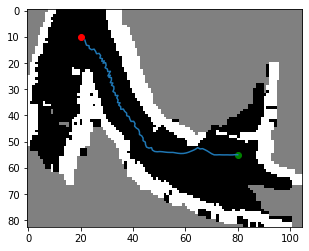

In [6]:
path = construct_path(total, start, goal, max_its=100)
path = np.array(path)
plt.imshow(grid, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')
plt.plot(path[:,0], path[:,1])